In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pandas import Series, DataFrame
import pathlib

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import shapely
import shapely.wkt
from shapely.geometry import Point, LineString

from typing import Sequence

In [2]:
# Read DTV Network
data_dir = pathlib.Path('~/data/river/dtv/network_digital_twin_v0.2').expanduser()
G = nx.read_gpickle(data_dir / 'network.pickle')

In [3]:
# Define locations for route

locaties = {
    'lobith': '8863233',
    'ketelmeer': '8863596',
    'kinderdijk': '8865140',
    'werkendam': '22638308',
    'griethausen': '8861160',
    'eijsden': '8867254',
    'keizersveer': '8863872',
    'molenhoek': '8865600',
    'nijmegen': '8861687'
}

In [4]:
# Select routes from network

#Netherlands
nodes_Waal = nx.shortest_path(G, locaties['lobith'], locaties['werkendam'])
nodes_Lek = nx.shortest_path(G, locaties['lobith'], locaties['kinderdijk'])
nodes_Ijssel = nx.shortest_path(G, locaties['lobith'], locaties['ketelmeer'])
# nodes_Maas = nx.shortest_path(G, locaties['eijsden'], locaties['keizersveer'])
# nodes_Maas_Waal = nx.shortest_path(G, locaties['molenhoek'], locaties['nijmegen'])



In [5]:
# Determine edges for each route
#TODO: What if we travel in the other direction?

Network_DTV = {}
for n_start, n_end in zip(nodes_Waal[:-1], nodes_Waal[1:]):
    e = G.edges[(n_start, n_end)]['Wkt']
    e = shapely.wkt.loads(e)
    Network_DTV[(n_start, n_end)] = e

for n_start, n_end in zip(nodes_Lek[:-1], nodes_Lek[1:]):
    e = G.edges[(n_start, n_end)]['Wkt']
    e = shapely.wkt.loads(e)
    Network_DTV[(n_start, n_end)] = e

for n_start, n_end in zip(nodes_Ijssel[:-1], nodes_Ijssel[1:]):
    e = G.edges[(n_start, n_end)]['Wkt']
    e = shapely.wkt.loads(e)
    Network_DTV[(n_start, n_end)] = e
    
# for n_start, n_end in zip(nodes_Maas[:-1], nodes_Maas[1:]):
#     e = G.edges[(n_start, n_end)]['Wkt']
#     e = shapely.wkt.loads(e)
#     Network_DTV[(n_start, n_end)] = e

# for n_start, n_end in zip(nodes_Maas_Waal[:-1], nodes_Maas_Waal[1:]):
#     e = G.edges[(n_start, n_end)]['Wkt']
#     e = shapely.wkt.loads(e)
#     Network_DTV[(n_start, n_end)] = e

In [6]:
# Read waterlevel data
waterlevel_path = pathlib.Path('~/data/river/dtv/ws.geojson').expanduser()
df = gpd.read_file(waterlevel_path)

# Select Waal, Rijn, Lek, IJssel data. (No Maas)
df = df.loc[df['reference_location'] == 'Lobith']
                 

In [7]:
def nearest_line(point: Point, lines: Sequence[LineString], keys: Sequence[tuple]) -> (int, float, tuple): 

    # For a point, find the nearest geometry from a list of points/lines
    #
    # point: Shapely Point
    # lines: List of shapely LineString
    # returns: index of nearest line, distance to nearest line
    d = np.full((len(lines)), fill_value=np.nan)
    for ii in range(len(lines)):
        d[ii] = point.distance(lines[ii])
    index = np.argmin(d)
    key = keys[index]
    return index, np.min(d), key

In [8]:
h = []
j = []
edge_ids = []
for index, p in df['geometry'].items():
    k, i, key = nearest_line (p, list(Network_DTV.values()), list(Network_DTV.keys()))
    h.append(k)
    j.append(i)
    edge_ids.append(key)

In [9]:
df['edge_id'] = edge_ids
# Add column with linestrings of the geometry values of edges of the DTV network, which corresponds with the waterlevel points.
df['edge_geometry'] = df['edge_id'].apply(lambda edge_id: Network_DTV[edge_id])
df['distance_geometry'] = j

geopandas.geodataframe.GeoDataFrame

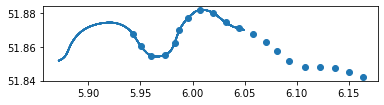

In [10]:
# Visual check above method
f, ax = plt.subplots()
df.iloc[0:20].plot(ax=ax)

df2 = df.set_geometry("edge_geometry")

df2.iloc[0:20].plot(ax=ax)

type(df)


In [11]:
# Select required columns for geojson

df_selected = df2[["reference_location", "discharge", "ws", "edge_geometry", "edge_id"]]


geopandas.geodataframe.GeoDataFrame

In [12]:
df_selected

,reference_location,discharge,ws,edge_geometry,edge_id
0,Lobith,703.3,7.04,"LINESTRING (6.04974 51.86988, 6.04614 51.87087...","(8863233, B25279_A)"
1,Lobith,703.3,6.9,"LINESTRING (6.04974 51.86988, 6.04614 51.87087...","(8863233, B25279_A)"
2,Lobith,703.3,6.76,"LINESTRING (6.04974 51.86988, 6.04614 51.87087...","(8863233, B25279_A)"
3,Lobith,703.3,6.63,"LINESTRING (6.04974 51.86988, 6.04614 51.87087...","(8863233, B25279_A)"
4,Lobith,703.3,6.52,"LINESTRING (6.04974 51.86988, 6.04614 51.87087...","(8863233, B25279_A)"
...,...,...,...,...,...
38983,Lobith,16140.64,1.17,"LINESTRING (5.85901 52.58327, 5.85845 52.58324...","(B6277_B, 8865643)"
38984,Lobith,16140.64,1.07,"LINESTRING (5.84434 52.58141, 5.84167 52.58174...","(8865643, 8862968)"
38985,Lobith,16140.64,0.99,"LINESTRING (5.83539 52.58294, 5.83351 52.58313...","(8862968, 8863596)"
38986,Lobith,16140.64,0.86,"LINESTRING (5.83539 52.58294, 5.83351 52.58313...","(8862968, 8863596)"


In [13]:
# Waterlevel and Discharge as float

df_selected['ws'] = df_selected['ws'].astype(float)
gdf_json['discharge'] = gdf['discharge'].apply(float)


# Group by edge id calculate mean for waterlevel
df_grouped = df_selected.groupby(['edge_id', 'discharge']).agg(
    reference_location = ('reference_location', 'first'),
    ws = ('ws', 'mean'),
    edge_geometry =('edge_geometry', 'first' )
)

# Convert again to geopandan...
gdf = gpd.GeoDataFrame(df_grouped, geometry='edge_geometry')

gdf = gdf.reset_index(level=[0,1])
gdf_json = gdf.copy()

# Convert edgi_id in string 
gdf_json['edge_id'] = gdf_json['edge_id'].map(lambda x: f'{x[0]}-{x[1]}')


gdf_json


/Users/gils_aa/miniforge3/envs/dtv-backend/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,edge_id,discharge,reference_location,ws,edge_geometry
0,22638029-22638308,10204.27,Lobith,2.911982,"LINESTRING (4.89171 51.81932, 4.89113 51.81909..."
1,22638029-22638308,1040.45,Lobith,0.681439,"LINESTRING (4.89171 51.81932, 4.89113 51.81909..."
2,22638029-22638308,10459.56,Lobith,2.979691,"LINESTRING (4.89171 51.81932, 4.89113 51.81909..."
3,22638029-22638308,10721.28,Lobith,3.047836,"LINESTRING (4.89171 51.81932, 4.89113 51.81909..."
4,22638029-22638308,1086.43,Lobith,0.702707,"LINESTRING (4.89171 51.81932, 4.89113 51.81909..."
...,...,...,...,...,...
9343,L8681_B-8868284,9476.79,Lobith,4.630000,"LINESTRING (5.13426 51.99267, 5.13335 51.99344..."
9344,L8681_B-8868284,958.35,Lobith,0.960000,"LINESTRING (5.13426 51.99267, 5.13335 51.99344..."
9345,L8681_B-8868284,9712.91,Lobith,4.730000,"LINESTRING (5.13426 51.99267, 5.13335 51.99344..."
9346,L8681_B-8868284,9955.40,Lobith,4.820000,"LINESTRING (5.13426 51.99267, 5.13335 51.99344..."


In [14]:
#Write to file

gdf_json.to_file("ws_grouped.geojson", driver='GeoJSON')

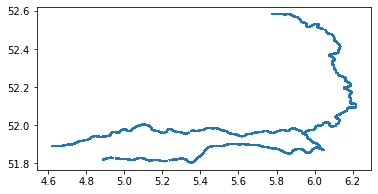

In [15]:
#plot edge with velocity data
gdf.plot();